# Global

In [221]:
global_var = {
    # Data
    'mesh_data_path' : "/content/mesh_data",
    'mesh_data_url' : "https://drive.google.com/uc?export=download&id=1nYTsCfq8kTaBd6WQUVN1bQqxE-hVM_O7",

    # Meshes
    'is_sphere' : False,

    # Renderer
    'renderer_distance' : 2.7,
    'renderer_image_size' : 128,
    'renderer_views' : 20,
    'renderer_blur_radius' : 0.0,
    'renderer_faces_per_pixel' : 1,

    # Rasterizer
    'raster_sigma' : 1e-4,
    'raster_faces_per_pixel' : 50,

    # Differentiable renderer
    'diff_rend_sigma' : 1e-4,
    'diff_rend_faces_per_pixel' : 50,

    # Networks
    'hidden_dim' : 256,
    'disp_dim' : 3,
    'norm_ratio' : 0.1,

    # Train
    'net_model' : "ffn",
    'num_views_per_iteration' : 2,
    'iters' : 6000,
    'plot_period' : 250,
    'inference' : False,
}

# Imports

In [205]:
!pip install open3d wget python-multipart fastapi uvicorn kaleido --quiet

In [206]:
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca --quiet
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4 --quiet

Reading package lists...
Building dependency tree...
Reading state information...
libgtk2.0-0 is already the newest version (2.24.33-2ubuntu2).
libgconf-2-4 is already the newest version (3.2.6-7ubuntu2).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.5).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [207]:
import kaleido
import locale
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import os
import plotly.graph_objects as go
import pickle as pkl
import shutil
import sys
import torch
import torch.nn as nn
import wget
import zipfile

from google.colab import files,output
from plotly.subplots import make_subplots
import plotly.io as pio
from time import perf_counter
from tqdm import tqdm
from tqdm import trange

%matplotlib inline

In [ ]:
# Pytorch 3D utilities
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath --quiet
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html --quiet
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable' --quiet

from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.utils import ico_sphere

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, save_obj
from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency,
)

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex,
    TexturesUV,
    Textures
)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 920.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 117.4 MB/s eta 0:00:00


# Utils

## Enable GPU

In [ ]:
def device_setup():
    """
        Initialize GPU
    """
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        torch.cuda.set_device(device)
    else:
        device = torch.device("cpu")

    print("[LOG] Currently working on", device)
    return device

In [ ]:
device = device_setup()

[LOG] Currently working on cuda:0


## Text encoding

In [ ]:
# Allow third part libraries
output.enable_custom_widget_manager()

# Setting UTF-8 encoding
locale.getpreferredencoding = lambda: "UTF-8"

# Dataset

## Download dataset

In [ ]:
def download_dataset(output_name,quiet=False,reset=False):
  if reset and os.path.exists(global_var['mesh_data_path']):
    !rm -r mesh_data

  if not os.path.exists(global_var['mesh_data_path']):
    print(f"[LOG] Starting dataset download...")
    wget.download(global_var['mesh_data_url'])
    print(f"[LOG] Download of dataset ended!")

  else:
    print("[LOG] Mesh dataset already downloaded!")

In [ ]:
download_dataset(output_name="mesh_data.zip",quiet=False,reset=True)

[LOG] Starting dataset download...
[LOG] Download of dataset ended!


## Extract dataset meshes

In [ ]:
def prepare_dataset_folder(zip_path):
  mesh_zip = '/content/'+zip_path
  final_dir = '/content/'

  if not os.path.exists(final_dir):
      os.makedirs(final_dir)

  with zipfile.ZipFile(mesh_zip, 'r') as zip_ref:
      zip_ref.extractall(final_dir)

  !rm -r mesh_data.zip
  print("[LOG] Successfully extracted the dataset in ", global_var['mesh_data_path'])

In [ ]:
prepare_dataset_folder("mesh_data.zip")

[LOG] Successfully extracted the dataset in  /content/mesh_data


## Get obj files

In [ ]:
def get_dataset_paths(dataset_path):
    """
        Return a list of all elements path in the dataset
    """
    meshes_paths = []

    for current_dir, _, files in os.walk(dataset_path):
        for elem in files:
            if ".obj" in elem:
                mesh_path = os.path.join(current_dir, elem)
                meshes_paths.append(mesh_path)

    meshes_paths.sort()
    return meshes_paths

In [ ]:
meshes_paths = get_dataset_paths(global_var['mesh_data_path'])

# 2D guidances

## Target 3D mesh

In [ ]:
# Normalize the mesh by putting on the center (0,0,0) of a sphere of radius 1
def mesh_normalization(mesh):
  verts = mesh.verts_packed()
  N = verts.shape[0]
  center = verts.mean(0)
  scale = max((verts - center).abs().max(0)[0])
  mesh.offset_verts_(-center)
  mesh.scale_verts_((1.0 / float(scale)))

In [ ]:
target_mesh_path = meshes_paths[0]
target_mesh = load_objs_as_meshes(
    [target_mesh_path],
    device=device)

mesh_normalization(target_mesh)

## Target 3D mesh visualization

In [ ]:
def mesh_visualization(obj_file_path, final="False"):
    mesh = o3d.io.read_triangle_mesh(obj_file_path)

    if mesh.is_empty(): exit()
    if not mesh.has_vertex_normals(): mesh.compute_vertex_normals()
    if not mesh.has_triangle_normals(): mesh.compute_triangle_normals()

    triangles = np.asarray(mesh.triangles)
    vertices = np.asarray(mesh.vertices)

    colors = None
    if mesh.has_triangle_normals():
        colors = (0.5, 0.5, 0.5) + np.asarray(mesh.triangle_normals) * 0.5
        colors = tuple(map(tuple, colors))
    else:
        colors = (1.0, 0.0, 0.0)

    if final:
      fig = go.Mesh3d(
            x=vertices[:,0],
            y=vertices[:,1],
            z=vertices[:,2],
            i=triangles[:,0],
            j=triangles[:,1],
            k=triangles[:,2],
            facecolor=colors,
            opacity=0.50
          )

    else:
      fig = go.Figure(
    data=[
        go.Mesh3d(
            x=vertices[:,0],
            y=vertices[:,1],
            z=vertices[:,2],
            i=triangles[:,0],
            j=triangles[:,1],
            k=triangles[:,2],
            facecolor=colors,
            opacity=0.50)
        ],
        layout=dict(
            scene=dict(
                xaxis=dict(visible=True),
                yaxis=dict(visible=True),
                zaxis=dict(visible=True)
            )
        )
    )
    return fig

In [ ]:
target_fig = mesh_visualization(target_mesh_path,final=False)
target_fig.show()

## 2D guidance acquisition

In [ ]:
def get_2d_guidances(mesh,distance,elevs,azims,img_size,blur_radius,faces_per_pixel,lights_loc,num_views,device):
  lights = PointLights(
      device=device,
      location=[lights_loc])

  R, T = look_at_view_transform(
      dist=distance,
      elev=elevs,
      azim=azims)

  cameras = FoVPerspectiveCameras(
      device=device,
      R=R,
      T=T)

  camera = FoVPerspectiveCameras(
      device=device,
      R=R[None, 1, ...],
      T=T[None, 1, ...])

  raster_settings = RasterizationSettings(
      image_size=img_size,
      blur_radius=blur_radius,
      faces_per_pixel=faces_per_pixel,
  )

  renderer = MeshRenderer(
      rasterizer=MeshRasterizer(
          cameras=camera,
          raster_settings=raster_settings
      ),
      shader=SoftPhongShader(
          device=device,
          cameras=camera,
          lights=lights
      )
  )

  meshes = mesh.extend(num_views)


  try:
    target_images = renderer(
      meshes,
      cameras=cameras,
      lights=lights)
  except:
    dummy_texture = Textures(
          faces_uvs=torch.zeros_like(mesh.faces_padded()).to(device),
          verts_uvs = torch.zeros([1, 48, 2]).to(device),
          maps=torch.rand((1, 256, 256, 3)).to(device)
        )
    mesh.textures = dummy_texture
    meshes = mesh.extend(num_views)
    target_images = renderer(
      meshes,
      cameras=cameras,
      lights=lights)

  target_cameras = [
      FoVPerspectiveCameras(
          device=device, R=R[None, i, ...],
          T=T[None, i, ...])
          for i in range(num_views)]

  return target_images, target_cameras, [camera,cameras,meshes,lights]

In [ ]:
target_images, target_cameras, render_args = get_2d_guidances(
    mesh = target_mesh,
    distance = global_var['renderer_distance'],
    elevs = torch.linspace(0, 360, global_var['renderer_views']),
    azims = torch.linspace(-180, 180, global_var['renderer_views']),
    img_size = global_var['renderer_image_size'],
    blur_radius = global_var['renderer_blur_radius'],
    faces_per_pixel = global_var['renderer_faces_per_pixel'],
    lights_loc = [0.0, 0.0, -3.0],
    num_views = global_var['renderer_views'],
    device=device)

In [ ]:
def show_guidances(images,rows,cols,raster_img=False):
    fig, axarr = plt.subplots(
        rows,
        cols,
        gridspec_kw = {"wspace": 0.0, "hspace": 0.0},
        figsize=(15, 9))

    fig.subplots_adjust(
        left=0,
        bottom=0,
        right=1,
        top=1)

    for ax, im in zip(axarr.ravel(), images):
      ax.imshow(im[..., 3]) if raster_img else ax.imshow(im[..., :3])
      ax.set_axis_off()

    plt.show()

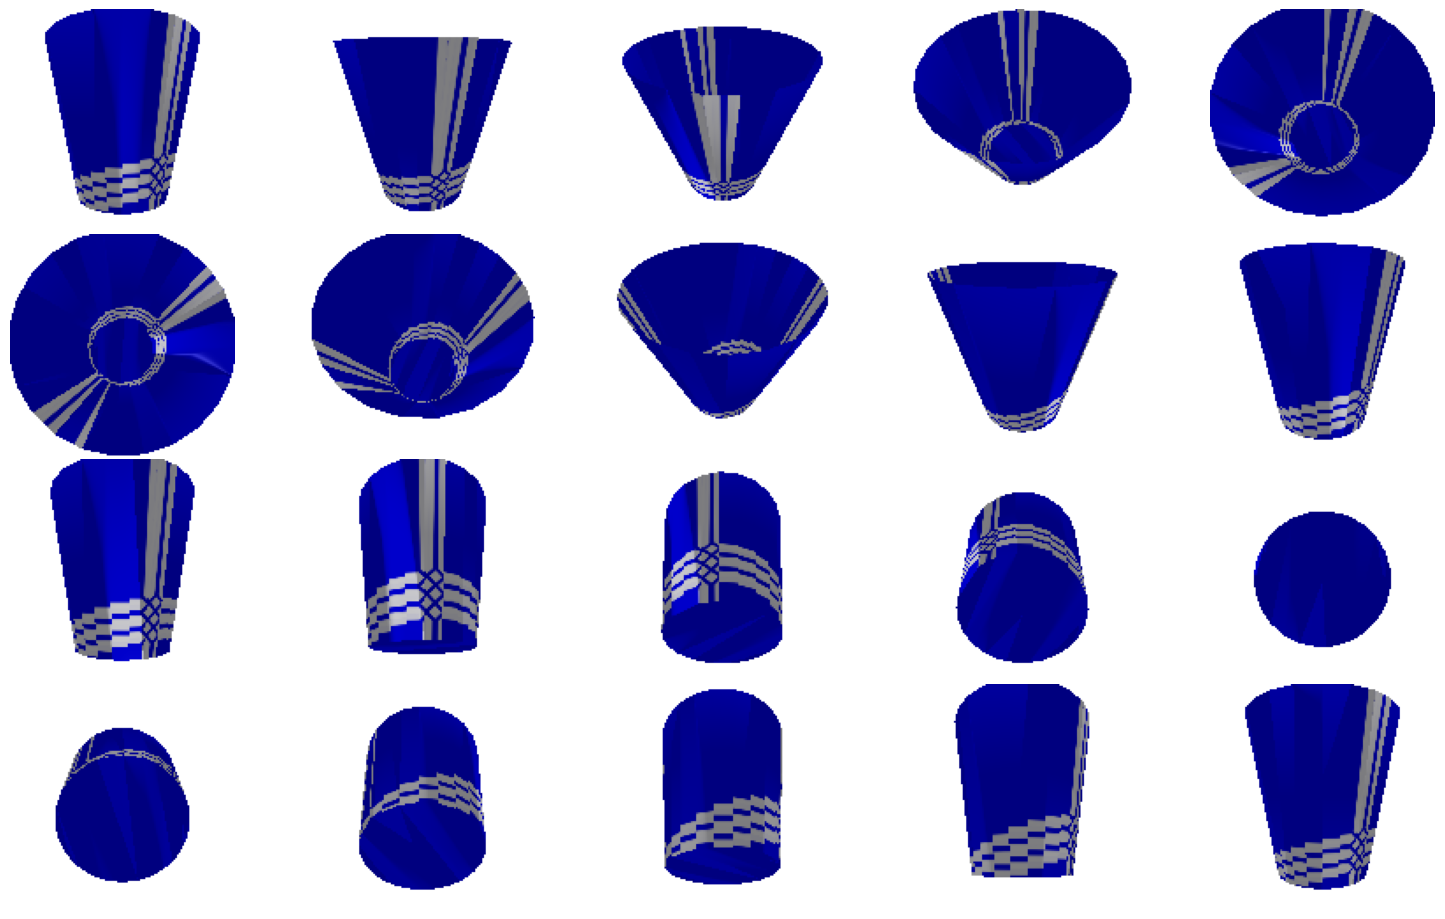

In [ ]:
show_guidances(target_images.cpu().numpy(), rows=4, cols=5, raster_img=False)

## 2D guidance rasterization

In [ ]:
rasterizer_blur = np.log(1.0/global_var['raster_sigma']-1.0)*global_var['raster_sigma']
raster_settings_silhouette = RasterizationSettings(
  image_size=global_var['renderer_image_size'],
  blur_radius=rasterizer_blur,
  faces_per_pixel=global_var['raster_faces_per_pixel'],
)

renderer_silhouette = MeshRenderer(
  rasterizer=MeshRasterizer(
      cameras=render_args[0],
      raster_settings=raster_settings_silhouette
  ),
  shader=SoftSilhouetteShader()
)

silhouette_images = renderer_silhouette(
    render_args[2],
    cameras=render_args[1],
    lights=render_args[3]
)

target_silhouette = [silhouette_images[i, ..., 3] for i in range(global_var['renderer_views'])]

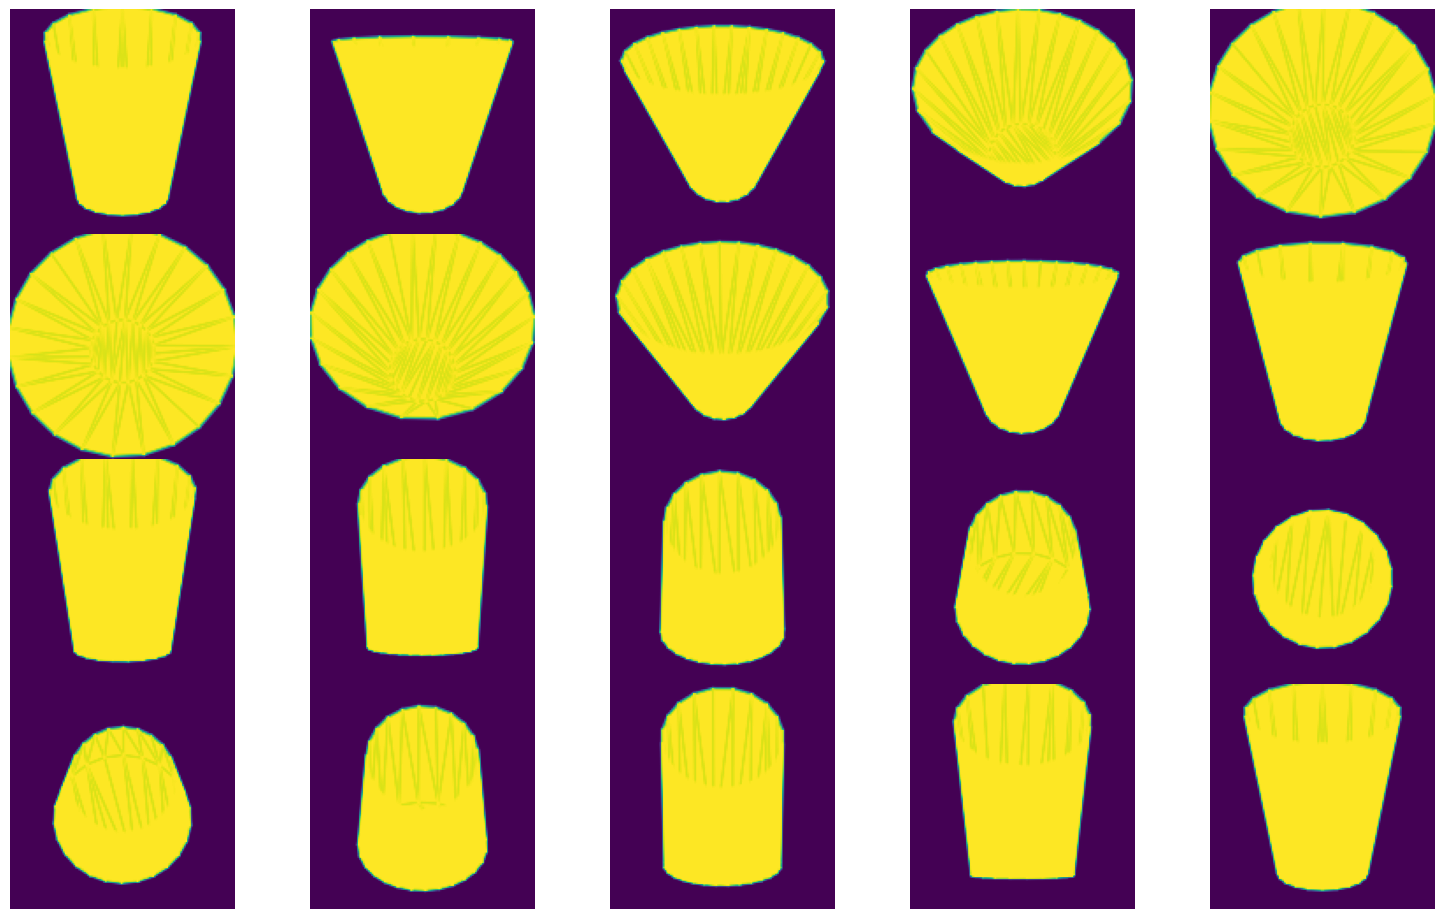

In [ ]:
show_guidances(silhouette_images.cpu().numpy(), rows=4, cols=5,raster_img=True)

# 3D shape

## Input 3D mesh

In [ ]:
def save_mesh(mesh,path="",prefix=""):
  verts, faces = mesh.get_mesh_verts_faces(0)
  center = verts.mean(0)
  scale = max((verts - center).abs().max(0)[0])
  verts = verts * scale + center
  if path == "":
    mesh_obj = os.path.join('./', name+'.obj')
    save_obj(mesh_obj,verts,faces)
  else:
    save_obj(path,verts,faces)
    print(f"[LOG] {prefix} deformed mesh saved!")

In [ ]:
if global_var['is_sphere']:
  source_mesh = ico_sphere(4, device)
  save_mesh(source_mesh,"sphere")
  source_mesh_path = "sphere.obj"
else:
  if os.path.exists("sphere.obj"):
    !rm -r sphere.obj

  source_mesh_path = meshes_paths[7]
  source_mesh = load_objs_as_meshes([source_mesh_path], device=device)

mesh_normalization(source_mesh)

## Input 3D mesh visualization

In [ ]:
src_fig = mesh_visualization(source_mesh_path,final=False)
src_fig.show()

# Loss

## Differentialble renderer

In [ ]:
diff_renderer_blur = np.log(1. / global_var['diff_rend_sigma'] - 1.)*global_var['diff_rend_sigma']
raster_settings_soft = RasterizationSettings(
    image_size=global_var['renderer_image_size'],
    blur_radius=diff_renderer_blur,
    faces_per_pixel=global_var['raster_faces_per_pixel'],
)

renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=render_args[0],
        raster_settings=raster_settings_soft
    ),
    shader=SoftSilhouetteShader()
)

## Images loss

In [ ]:
def images_loss(mesh,num_views,views_per_iteration,lights,target_cameras):
  l2_loss = 0.0

  for j in np.random.permutation(num_views).tolist()[:views_per_iteration]:
    images_predicted = renderer_silhouette(mesh, cameras=target_cameras[j], lights=lights)
    predicted_silhouette = images_predicted[..., 3]
    loss_silhouette = ((predicted_silhouette - target_silhouette[j]) ** 2).mean()
    l2_loss += loss_silhouette / global_var['num_views_per_iteration']

  return l2_loss

## Composite loss

In [ ]:
def update_loss(mesh,loss,losses,lights,renderer_silhouette,target_cameras,num_views,views_per_iteration):
  loss["edge"] = mesh_edge_loss(mesh)
  loss["normal"] = mesh_normal_consistency(mesh)
  loss["laplacian"] = mesh_laplacian_smoothing(mesh, method="uniform")
  loss["silhouette"] = images_loss(mesh,num_views,views_per_iteration,lights,target_cameras)

  total_loss = torch.tensor(0.0, device=device)
  for k, l in loss.items():
      total_loss += l * losses[k]["weight"]
      losses[k]["values"].append(float(l.detach().cpu()))

  return total_loss

# Deforming systems

## DeFormNet

In [ ]:
class DeformNet(nn.Module):
  def __init__(self, verts_dim=3, hidden_dim=256, disp_dim=3, norm_ratio=0.1):
    super(DeformNet, self).__init__()

    self.l1 = nn.Linear(verts_dim,hidden_dim)
    self.a1 = nn.ReLU()
    self.l2 = nn.Linear(hidden_dim,hidden_dim)
    self.a2 = nn.ReLU()
    self.l3 = nn.Linear(hidden_dim,disp_dim)
    self.norm_ratio = norm_ratio

  def forward(self,x):
    x = self.l1(x)
    x = self.a1(x)
    x = self.l2(x)
    x = self.a2(x)
    x = self.l3(x) * self.norm_ratio

    return x

## Neural Style Field

In [ ]:
class NeuralStyleField(nn.Module):
    def __init__(self, verts_dim=3, hidden_dim=256, disp_dim=3, norm_ratio=0.1):
        super(NeuralStyleField, self).__init__()

        # Positional Encoding
        self.pos_enc_layer = nn.Linear(verts_dim,hidden_dim)
        self.pos_enc_act = nn.ReLU()

        # Vertices embedding
        self.vert_emb_layer_1 = nn.Linear(hidden_dim, hidden_dim)
        self.vert_emb_act_1 = nn.ReLU()
        self.vert_emb_layer_2 = nn.Linear(hidden_dim, hidden_dim)
        self.vert_emb_act_2 = nn.ReLU()
        self.vert_emb_layer_3 = nn.Linear(hidden_dim, hidden_dim)
        self.vert_emb_act_3 = nn.ReLU()
        self.vert_emb_layer_4 = nn.Linear(hidden_dim, hidden_dim)
        self.vert_emb_act_4 = nn.ReLU()

        # Displacement prediction
        self.disp_pred_layer_1 = nn.Linear(hidden_dim, hidden_dim)
        self.disp_pred_act_1 = nn.ReLU()
        self.disp_pred_layer_2 = nn.Linear(hidden_dim, hidden_dim)
        self.disp_pred_act_2 = nn.ReLU()
        self.disp_pred_layer_3 = nn.Linear(hidden_dim, disp_dim)
        self.disp_pred_act_3 = nn.Tanh()
        self.norm_ratio = norm_ratio

    def forward(self, x):
        # pos_enc_layer_out = self.pos_enc_layer(x)
        pos_enc_layer_out = torch.nn.functional.linear(x,self.pos_enc_layer.weight.clone(),self.pos_enc_layer.bias)
        pos_enc_act_out = self.pos_enc_act(pos_enc_layer_out)

        # vert_emb_layer_out_1 = self.vert_emb_layer_1(pos_enc_act_out)
        vert_emb_layer_out_1 = torch.nn.functional.linear(pos_enc_act_out,self.vert_emb_layer_1.weight.clone(),self.vert_emb_layer_1.bias)
        vert_emb_act_out_1 = self.vert_emb_act_1(vert_emb_layer_out_1)

        # vert_emb_layer_out_2 = self.vert_emb_layer_2(vert_emb_act_out_1)
        vert_emb_layer_out_2 = torch.nn.functional.linear(vert_emb_act_out_1,self.vert_emb_layer_2.weight.clone(),self.vert_emb_layer_2.bias)
        vert_emb_act_out_2 = self.vert_emb_act_2(vert_emb_layer_out_2)

        # vert_emb_layer_out_3 = self.vert_emb_layer_3(vert_emb_act_out_2)
        vert_emb_layer_out_3 = torch.nn.functional.linear(vert_emb_act_out_2,self.vert_emb_layer_3.weight.clone(),self.vert_emb_layer_3.bias)
        vert_emb_act_out_3 = self.vert_emb_act_3(vert_emb_layer_out_3)

        # vert_emb_layer_out_4 = self.vert_emb_layer_4(vert_emb_act_out_3)
        vert_emb_layer_out_4 = torch.nn.functional.linear(vert_emb_act_out_3,self.vert_emb_layer_4.weight.clone(),self.vert_emb_layer_4.bias)
        vert_emb_act_out_4 = self.vert_emb_act_4(vert_emb_layer_out_4)

        # disp_pred_layer_out_1 = self.disp_pred_layer_1(vert_emb_act_out_4)
        disp_pred_layer_out_1 = torch.nn.functional.linear(vert_emb_act_out_4,self.disp_pred_layer_1.weight.clone(),self.disp_pred_layer_1.bias)
        disp_pred_act_out_1 = self.disp_pred_act_1(disp_pred_layer_out_1)

        # disp_pred_layer_out_2 = self.disp_pred_layer_2(disp_pred_act_out_1)
        disp_pred_layer_out_2 = torch.nn.functional.linear(disp_pred_act_out_1,self.disp_pred_layer_2.weight.clone(),self.disp_pred_layer_2.bias)
        disp_pred_act_out_2 = self.disp_pred_act_2(disp_pred_layer_out_2)

        # disp_pred_layer_out_3 = self.disp_pred_layer_3(disp_pred_act_out_2)
        disp_pred_layer_out_3 = torch.nn.functional.linear(disp_pred_act_out_2,self.disp_pred_layer_3.weight.clone(),self.disp_pred_layer_3.bias)
        out = self.disp_pred_act_3(disp_pred_layer_out_3) * self.norm_ratio


        return out

# Train

## Train initialization

In [ ]:
verts_shape = source_mesh.verts_packed().shape
loss_history = {
    "silhouette": {"weight": 1.0, "values": []},
    "edge": {"weight": 1.0, "values": []},
    "normal": {"weight": 0.01, "values": []},
    "laplacian": {"weight": 1.0, "values": []},
}

if global_var['net_model'] == "ffn":
  use_net = True
  model = DeformNet(
    verts_dim=verts_shape[1],
    hidden_dim = global_var['hidden_dim'],
    disp_dim = global_var['disp_dim'],
    norm_ratio = global_var['norm_ratio']
  ).to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=1.0, momentum=0.9)

if global_var['net_model'] == "nsf":
  use_net = True
  model = NeuralStyleField(
    verts_dim=verts_shape[1],
    hidden_dim = global_var['hidden_dim'],
    disp_dim = global_var['disp_dim'],
    norm_ratio = global_var['norm_ratio']
  ).to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=1.0, momentum=0.9)

if global_var['net_model'] == "vec":
  use_net = False
  model = torch.full(
      verts_shape,
      0.0,
      device=device,
      requires_grad=True
  )
  optimizer = torch.optim.SGD([model], lr=1.0, momentum=0.9)

## Train loop

In [ ]:
def visualize_prediction(predicted_mesh, renderer,
                         target_image, title='',
                         save=False,
                         path=""):

    with torch.no_grad():
        predicted_images = renderer(predicted_mesh)

    plt.figure(figsize=(10, 4))
    plt.suptitle(title)

    plt.subplot(1, 2, 1)
    plt.imshow(predicted_images[0, ..., 3].cpu().detach().numpy())
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(target_image.cpu().detach().numpy())
    plt.axis("off")

    if save:
      plt.savefig(path)

In [ ]:
def train(model,model_name,device,optimizer,
          iters,source_mesh,render_args,
          renderer_silhouette,target_cameras,
          losses,plot_period,target_silhouette,
          num_views,views_per_iteration,
          net=True,inference=False):
  with trange(iters,desc="Train", unit="", position=0, leave=True) as train_loop:
    for i in train_loop:
      # Initialize optimizer
      if net:
        model.train()
      optimizer.zero_grad()

      # Predict deformation
      if net:
        inputs = source_mesh.verts_packed().to(device)
        deform_verts = model(inputs)
      else:
        deform_verts = model

      # Deform the mesh
      new_src_mesh = source_mesh.offset_verts(deform_verts)

      # Losses to smooth /regularize the mesh shape
      loss = {k: torch.tensor(0.0, device=device) for k in losses}
      compost_loss = update_loss(
          new_src_mesh,
          loss,
          losses,
          lights=render_args[3],
          renderer_silhouette=renderer_silhouette,
          target_cameras=target_cameras,
          num_views=num_views,
          views_per_iteration=views_per_iteration
      )

      # Print the losses
      train_loop.set_description("total_loss = %.6f" % compost_loss)

      # Plot mesh
      if not inference and i % plot_period == 0:
        visualize_prediction(
            new_src_mesh,
            renderer=renderer_silhouette,
            target_image=target_silhouette,
            title="Deformed vs Guidance at iter: %d" % i,
        )

      # Optimization step
      compost_loss.backward()
      optimizer.step()

  if net:
    return new_src_mesh, model.state_dict()
  else:
    return new_src_mesh, None

In [ ]:
def get_device():
  if device == "cpu":
    dev = !lscpu |grep 'Model name'
    dev = str(dev).strip("]'").split(":")[1].strip()
    print("Experiment runned throught Colab CPU:", dev)
    gpu = False

  else:
    dev = !nvidia-smi --query-gpu=gpu_name --format=csv
    print("Experiment runned throught Colab GPU:", dev[1])
    gpu = True

  return gpu

Experiment runned throught Colab GPU: Tesla T4


Train:   0%|          | 0/2000 [00:00<?, ?/s]/usr/local/lib/python3.10/dist-packages/pytorch3d/ops/laplacian_matrices.py:49: UserWarning:

torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)

total_loss = 0.162011: 100%|██████████| 2000/2000 [01:18<00:00, 25.47/s]


[LOG] Shape deformation in 78.5571 seconds


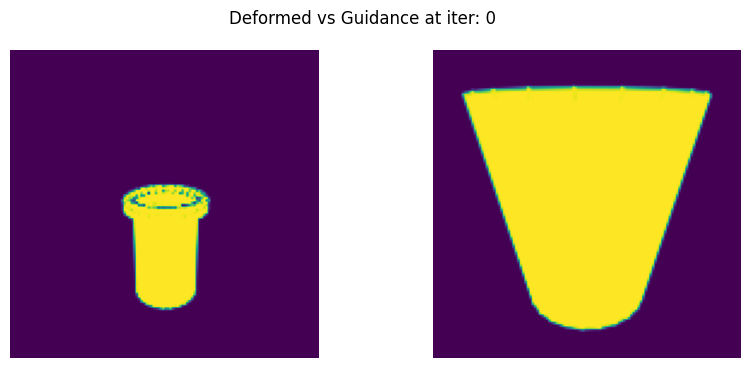

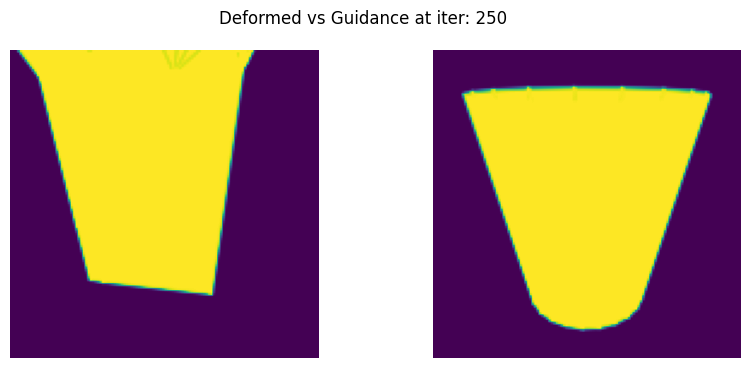

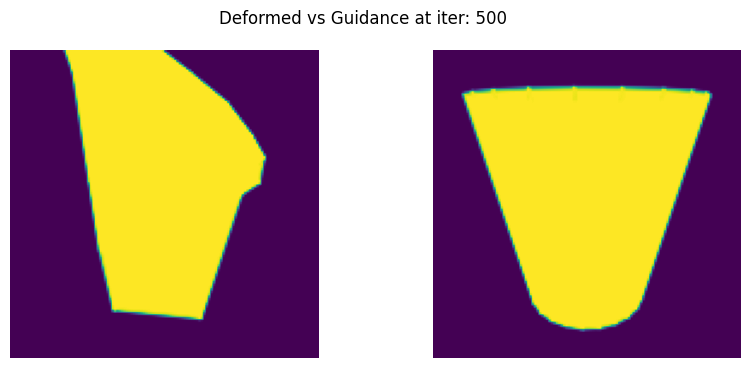

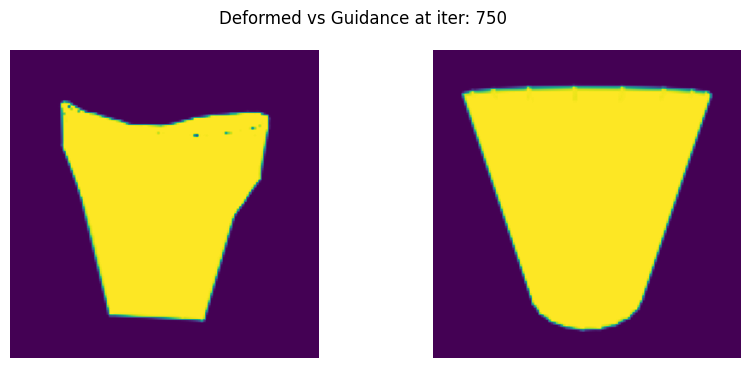

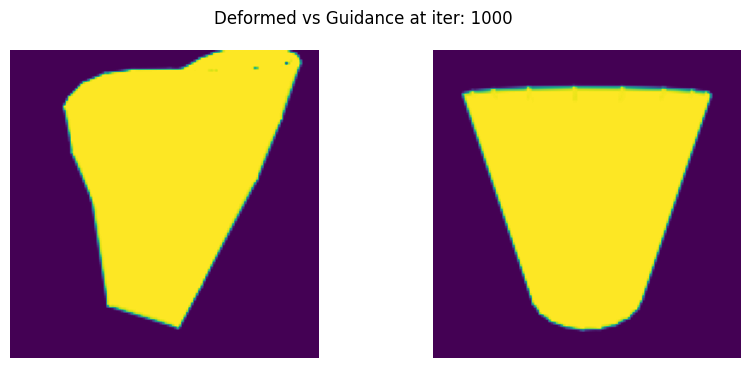

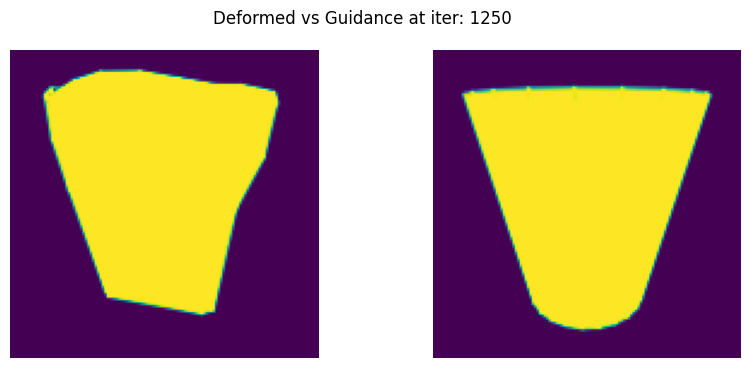

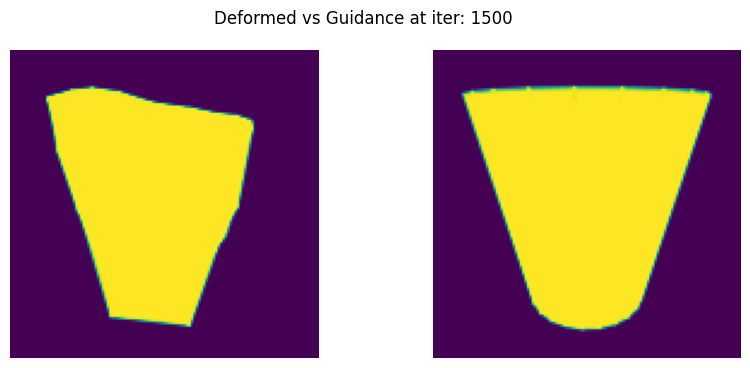

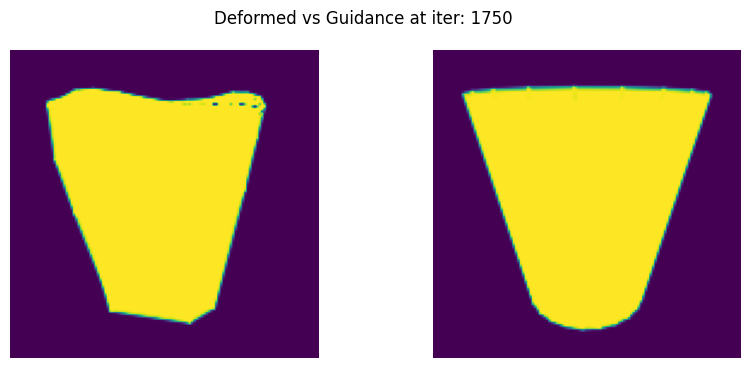

In [ ]:
syncro = get_device()

start_time = perf_counter()
deformed_mesh, model_weights = train(
    model = model,
    model_name = global_var['net_model'],
    device = device,
    optimizer = optimizer,
    iters = global_var['iters'],
    source_mesh = source_mesh,
    render_args = render_args,
    renderer_silhouette = renderer_silhouette,
    target_cameras = target_cameras,
    losses = loss_history,
    plot_period = global_var['plot_period'],
    target_silhouette = target_silhouette[1],
    num_views = global_var['renderer_views'],
    views_per_iteration = global_var['num_views_per_iteration'],
    net = use_net,
    inference = global_var['inference']
)

torch.cuda.synchronize() if syncro else None
end_time = perf_counter()

elapsed_time = end_time - start_time
print(f"[LOG] Shape deformation in {elapsed_time:.4f} seconds")

# Evaluation

## Results directory

In [ ]:
def get_titles_prefix(model_name):
  if model_name == "vec":
    prefix = "Baseline"
  elif model_name == 'ffn':
    prefix = "DeFormNet"
  else:
    prefix = "NSF"

  print(f"[LOG] Starting saving results for {prefix}")

  return prefix

In [177]:
def create_results_dir(source_mesh_path,target_mesh_path,syncro):
  source_name = source_mesh_path.strip().split("/")[3]
  target_name = target_mesh_path.strip().split("/")[3]
  dev_name = "gpu" if syncro else "cpu"
  results_dir_name = "[" + dev_name + "] " + source_name + "-to-" + target_name
  sub_directories = [
      "3d_shape_comparison",
      "final_render",
      "losses",
      "networks_models",
      "obj_models"
  ]

  if not os.path.exists(results_dir_name):
    os.mkdir(results_dir_name)

  for idx in range(len(sub_directories)):
    sub_path = os.path.join(results_dir_name, sub_directories[idx])
    sub_directories[idx] = sub_path
    if not os.path.exists(sub_path):
      os.makedirs(sub_path)

  print(f"[LOG] Results directory created with name: '{results_dir_name}'")
  return results_dir_name,sub_directories

In [ ]:
prefix = get_titles_prefix(global_var["net_model"])
results_dir_name,sub_directories = create_results_dir(source_mesh_path,target_mesh_path,syncro)

[LOG] Starting saving results for DeFormNet
[LOG] Results directory created with name: '[gpu] super_mario_tube-to-basket'


## Save model weights

In [ ]:
def save_model_weights(prefix,weights_path,weights):
  if prefix == "Baseline":
    print(f"[LOG] {prefix} doesn't have weights!")
  else:
    with open(weights_path, 'wb') as file:
      pkl.dump(weights, file)
    print(f"[LOG] {prefix} weights saved!")

In [ ]:
weights_path = sub_directories[3] + "/" + global_var['net_model'] + "_weights.pkl"
save_model_weights(prefix,weights_path,model_weights)

[LOG] DeFormNet weights saved!


## Save final 3D shape

In [ ]:
deformed_path = sub_directories[4] + "/" + global_var['net_model'] + "_deformed_mesh.obj"
mesh_normalization(deformed_mesh)
save_mesh(deformed_mesh,deformed_path,prefix)

[LOG] DeFormNet deformed mesh saved!


## Loss trend

In [ ]:
def plot_losses(prefix,losses,path):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()
    for k, l in losses.items():
        ax.plot(l['values'], label=k + " loss")
    ax.legend(fontsize="16")
    ax.set_xlabel("Iteration", fontsize="16")
    ax.set_ylabel("Loss", fontsize="16")
    ax.set_title(f"{prefix} composite loss", fontsize="16")

    plt.savefig(path)

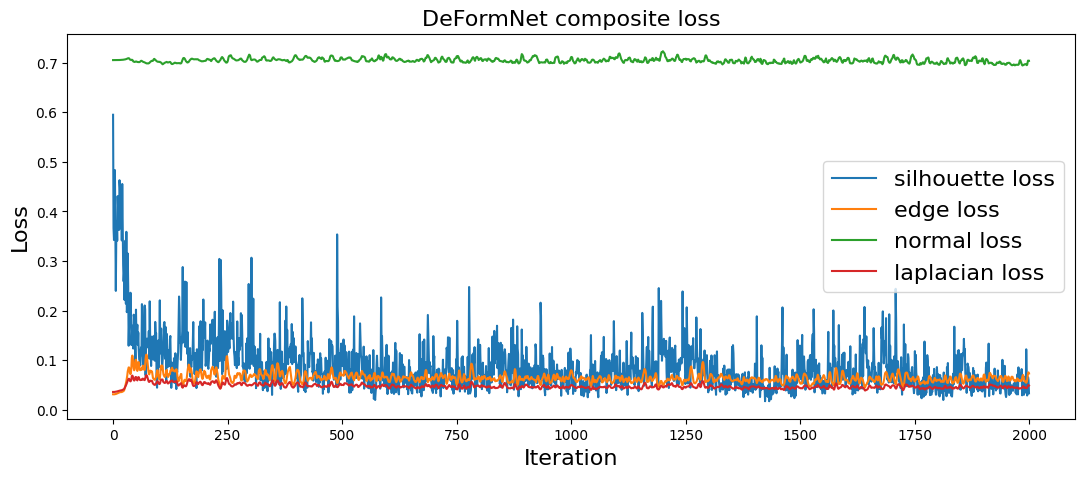

In [ ]:
losses_path = sub_directories[2] + "/" + global_var['net_model'] + "_composite_loss.jpg"
plot_losses(prefix,loss_history,losses_path)

## Predicted deformed shape rendered

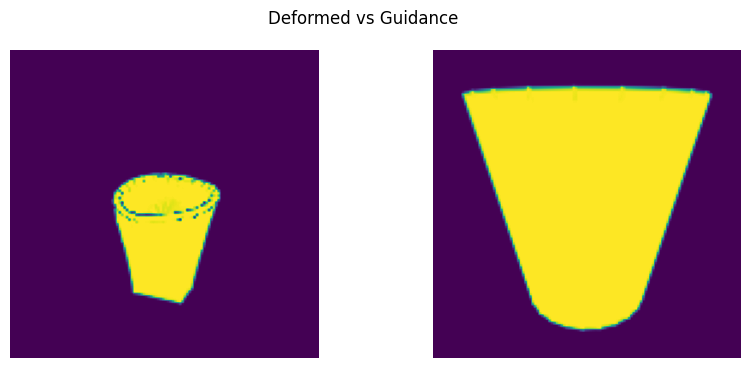

In [ ]:
render_path = sub_directories[1] + "/" + global_var['net_model'] + "_2d_visual.jpg"

visualize_prediction(
    deformed_mesh,
    renderer=renderer_silhouette,
    title = "Deformed vs Guidance",
    target_image=target_silhouette[1],
    save = True,
    path = render_path
  )

## Shapes comparison

In [ ]:
def final_pointcloud(prefix,src_mesh,final_mesh,path):
    src_points = sample_points_from_meshes(src_mesh, 20000)
    src_x, src_y, src_z = src_points.clone().detach().cpu().squeeze().unbind(1)

    final_points = sample_points_from_meshes(final_mesh, 20000)
    final_x, final_y, final_z = final_points.clone().detach().cpu().squeeze().unbind(1)

    fig = plt.figure(figsize=(16, 16))

    ax = fig.add_subplot(121, projection='3d')
    ax.scatter3D(src_x, src_z, -src_y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(prefix + " target mesh")
    ax.view_init(190, 30)

    ax = fig.add_subplot(122, projection='3d')
    ax.scatter3D(final_x, final_z, -final_y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(prefix + " deformed source")
    ax.view_init(190, 30)

    plt.show()
    fig.savefig(path)

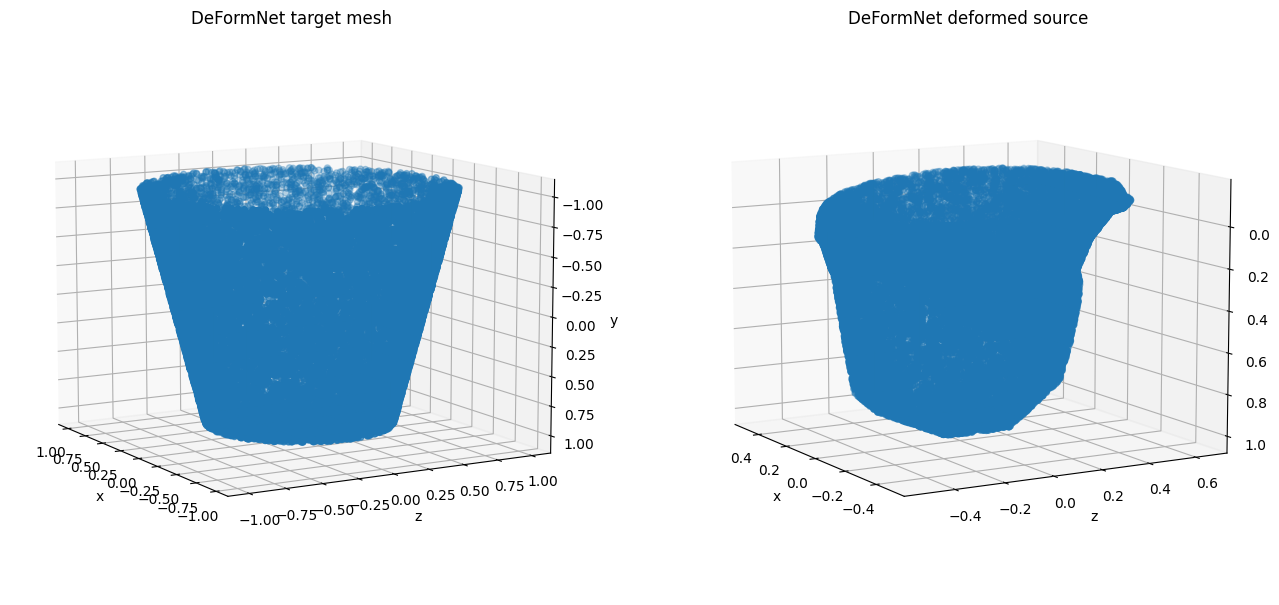

In [ ]:
pointcloud_path = sub_directories[0] + "/" + global_var['net_model'] + "_pointcloud.jpg"
final_pointcloud(prefix,target_mesh,deformed_mesh,pointcloud_path)

In [210]:
fig_3d_path = sub_directories[0] + "/" + global_var["net_model"] + "_3d.jpg"

src_fig = mesh_visualization(target_mesh_path)
final_fig = mesh_visualization(deformed_path)

fig = make_subplots(rows=1, cols=2,
                    specs=[[{'is_3d': True}, {'is_3d': True}]],
                    print_grid=False)

fig.append_trace(src_fig,row=1,col=1)
fig.append_trace(final_fig,row=1,col=2)
fig.update_layout(width=1000, margin=dict(r=10, l=10, b=10, t=10))
fig.update_layout(scene_aspectmode='cube')
fig.update_layout(scene_aspectmode='manual',
                  scene_aspectratio=dict(x=1, y=1, z=2))
fig.update_layout(scene_aspectmode='data')
fig.update_layout(scene_aspectmode='auto')
fig.write_image(fig_3d_path)

fig.show()

## Chamfer distance

In [ ]:
def get_chamfer_distance(trg_mesh,out_mesh):
  cloud_target = sample_points_from_meshes(trg_mesh, 50000)
  cloud_output = sample_points_from_meshes(out_mesh, 50000)

  return chamfer_distance(cloud_target,cloud_output)[0]

## Hausdorff distance

In [ ]:
def get_hausdorff_distance(mesh1, mesh2):
    vertices1 = mesh1.verts_packed()
    vertices2 = mesh2.verts_packed()

    dist1 = torch.cdist(vertices1, vertices2, p=2).min(dim=1)[0]
    dist2 = torch.cdist(vertices2, vertices1, p=2).min(dim=1)[0]
    hausdorff_distance = max(dist1.max().item(), dist2.max().item())

    return hausdorff_distance

## Frobenius norm

In [ ]:
def get_frobenius_norm(mesh1, mesh2, num_points=1000):
    points1 = sample_points_from_meshes(mesh1, num_points)
    points2 = sample_points_from_meshes(mesh2, num_points)

    norm = torch.norm(points1 - points2, p='fro', dim=-1)
    mean_norm = torch.mean(norm)

    return mean_norm

## Deformed mesh statistics

In [ ]:
def evaluation_measures(prefix,target_mesh,output_mesh,path,elapsed_time):
  stats_dict = {"Chamfer" : 0.0, "Hausdroff" : 0.0, "Frobenius" : 0.0, "Time" : 0.0}

  stats_dict["Chamfer"] = get_chamfer_distance(target_mesh,output_mesh)
  stats_dict["Hausdroff"] = get_hausdorff_distance(target_mesh,output_mesh)
  stats_dict["Frobenius"] = get_frobenius_norm(target_mesh,output_mesh)
  stats_dict["Time"] = elapsed_time

  with open(path, 'w') as file:
    for key, value in stats_dict.items():
      file.write(f"{key} = {value}\n")
      print(f"[LOG] {prefix} {key}: {value:.4f}")

In [ ]:
eval_path = sub_directories[2] + "/" + global_var["net_model"] + "_stats.txt"
evaluation_measures(prefix,target_mesh,deformed_mesh,eval_path,elapsed_time)

[LOG] DeFormNet Chamfer: 0.3327
[LOG] DeFormNet Hausdroff: 1.0960
[LOG] DeFormNet Frobenius: 1.1166
[LOG] DeFormNet Time: 78.5571


# Experiments

## Perform experiments

In [227]:
def run_experiment(source_mesh_idx,target_mesh_idx,model_name,model_id,mesh_names):
  print(f"********************************** {mesh_names}: Starting {model_name} experiment **********************************")
  ##################################### Target mesh #####################################
  target_mesh_path = meshes_paths[target_mesh_idx]
  target_mesh = load_objs_as_meshes([target_mesh_path],device=device)
  mesh_normalization(target_mesh)

  ##################################### 2D guidances #####################################
  target_images, target_cameras, render_args = get_2d_guidances(
    mesh = target_mesh,
    distance = global_var['renderer_distance'],
    elevs = torch.linspace(0, 360, global_var['renderer_views']),
    azims = torch.linspace(-180, 180, global_var['renderer_views']),
    img_size = global_var['renderer_image_size'],
    blur_radius = global_var['renderer_blur_radius'],
    faces_per_pixel = global_var['renderer_faces_per_pixel'],
    lights_loc = [0.0, 0.0, -3.0],
    num_views = global_var['renderer_views'],
    device=device)

  ##################################### 2D rasterized guidances #####################################
  rasterizer_blur = np.log(1.0/global_var['raster_sigma']-1.0)*global_var['raster_sigma']
  raster_settings_silhouette = RasterizationSettings(
    image_size=global_var['renderer_image_size'],
    blur_radius=rasterizer_blur,
    faces_per_pixel=global_var['raster_faces_per_pixel'],
  )

  renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=render_args[0],
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
  )

  silhouette_images = renderer_silhouette(
      render_args[2],
      cameras=render_args[1],
      lights=render_args[3]
  )

  target_silhouette = [silhouette_images[i, ..., 3] for i in range(global_var['renderer_views'])]

  ##################################### Source mesh #####################################
  if global_var['is_sphere']:
    source_mesh = ico_sphere(4, device)
    save_mesh(source_mesh,"sphere")
    source_mesh_path = "sphere.obj"
  else:
    if os.path.exists("sphere.obj"):
      !rm -r sphere.obj

    source_mesh_path = meshes_paths[source_mesh_idx]
    source_mesh = load_objs_as_meshes([source_mesh_path], device=device)

  mesh_normalization(source_mesh)

  ##################################### Differentiable rendered #####################################
  diff_renderer_blur = np.log(1. / global_var['diff_rend_sigma'] - 1.)*global_var['diff_rend_sigma']
  raster_settings_soft = RasterizationSettings(
      image_size=global_var['renderer_image_size'],
      blur_radius=diff_renderer_blur,
      faces_per_pixel=global_var['raster_faces_per_pixel'],
  )

  renderer_silhouette = MeshRenderer(
      rasterizer=MeshRasterizer(
          cameras=render_args[0],
          raster_settings=raster_settings_soft
      ),
      shader=SoftSilhouetteShader()
  )

  ##################################### Train initialization #####################################
  verts_shape = source_mesh.verts_packed().shape
  loss_history = {
      "silhouette": {"weight": 1.0, "values": []},
      "edge": {"weight": 1.0, "values": []},
      "normal": {"weight": 0.1, "values": []},
      "laplacian": {"weight": 1.0, "values": []},
  }

  if model_id == "ffn":
    use_net = True
    model = DeformNet(
      verts_dim=verts_shape[1],
      hidden_dim = global_var['hidden_dim'],
      disp_dim = global_var['disp_dim'],
      norm_ratio = global_var['norm_ratio']
    ).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

  if model_id == "nsf":
    use_net = True
    model = NeuralStyleField(
      verts_dim=verts_shape[1],
      hidden_dim = global_var['hidden_dim'],
      disp_dim = global_var['disp_dim'],
      norm_ratio = global_var['norm_ratio']
    ).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

  if model_id == "vec":
    use_net = False
    model = torch.full(
        verts_shape,
        0.0,
        device=device,
        requires_grad=True
    )
    optimizer = torch.optim.SGD([model], lr=0.001, momentum=0.9)

  ##################################### Train loop #####################################
  syncro = get_device()

  start_time = perf_counter()
  deformed_mesh, model_weights = train(
      model = model,
      model_name = model_id,
      device = device,
      optimizer = optimizer,
      iters = global_var['iters'],
      source_mesh = source_mesh,
      render_args = render_args,
      renderer_silhouette = renderer_silhouette,
      target_cameras = target_cameras,
      losses = loss_history,
      plot_period = global_var['plot_period'],
      target_silhouette = target_silhouette[1],
      num_views = global_var['renderer_views'],
      views_per_iteration = global_var['num_views_per_iteration'],
      net = use_net,
      inference = True
  )

  torch.cuda.synchronize() if syncro else None
  end_time = perf_counter()

  elapsed_time = end_time - start_time
  print(f"[LOG] Shape deformation in {elapsed_time:.4f} seconds")

  ##################################### Results directory #####################################
  prefix = get_titles_prefix(model_id)
  results_dir_name,sub_directories = create_results_dir(source_mesh_path,target_mesh_path,syncro)

  ##################################### Save network weights #####################################
  weights_path = sub_directories[3] + "/" + model_id + "_weights.pkl"
  save_model_weights(prefix,weights_path,model_weights)

  ##################################### Save deformed mesh #####################################
  deformed_path = sub_directories[4] + "/" + model_id + "_deformed_mesh.obj"
  mesh_normalization(deformed_mesh)
  save_mesh(deformed_mesh,deformed_path,prefix)

  ##################################### Save loss trend #####################################
  losses_path = sub_directories[2] + "/" + model_id + "_composite_loss.jpg"
  plot_losses(prefix,loss_history,losses_path)

  ##################################### Save rendered deformed mesh #####################################
  render_path = sub_directories[1] + "/" + model_id + "_2d_visual.jpg"

  visualize_prediction(
      deformed_mesh,
      renderer=renderer_silhouette,
      title = "Deformed vs Guidance",
      target_image=target_silhouette[1],
      save = True,
      path = render_path
    )

  ##################################### Save 3d deformed mesh #####################################
  pointcloud_path = sub_directories[0] + "/" + model_id + "_pointcloud.jpg"
  final_pointcloud(prefix,target_mesh,deformed_mesh,pointcloud_path)

  eval_path = sub_directories[2] + "/" + model_id + "_stats.txt"
  evaluation_measures(prefix,target_mesh,deformed_mesh,eval_path,elapsed_time)

  fig_3d_path = sub_directories[0] + "/" + model_id + "_3d.jpg"

  src_fig = mesh_visualization(target_mesh_path)
  final_fig = mesh_visualization(deformed_path)

  fig = make_subplots(rows=1, cols=2,
                      specs=[[{'is_3d': True}, {'is_3d': True}]],
                      print_grid=False)

  fig.append_trace(src_fig,row=1,col=1)
  fig.append_trace(final_fig,row=1,col=2)
  fig.update_layout(width=1000, margin=dict(r=10, l=10, b=10, t=10))
  fig.update_layout(scene_aspectmode='cube')
  fig.update_layout(scene_aspectmode='manual',
                    scene_aspectratio=dict(x=1, y=1, z=2))
  fig.update_layout(scene_aspectmode='data')
  fig.update_layout(scene_aspectmode='auto')
  fig.write_image(fig_3d_path)

  print(f"********************************** {mesh_names}:{model_name} experiment ended **********************************\n")

In [ ]:
# experiments_couples = {
#     "tube-basket" : {"idxs" : [7,0] },
#     "bunny-cow" : {"idxs" : [1,3] },
#     "chair-sofa" : {"idxs" : [2,6]},
#     "old-young" : {"idxs" : [5,4]}
# }
experiments_couples = {"tube-basket" : {"idxs" : [7,0] , "fig" : []}}
models = ["vec","ffn","nsf"]
model_names = ["Baseline","DeFormNet","NeuralStyleField"]

for key, value in experiments_couples.items():
  for idx in range(len(models)):
    run_experiment(
        source_mesh_idx = value["idxs"][0],
        target_mesh_idx = value["idxs"][1],
        model_name = model_names[idx],
        model_id = models[idx],
        mesh_names = key
    )

********************************** tube-basket: Starting Baseline experiment **********************************
Experiment runned throught Colab GPU: Tesla T4


total_loss = 0.315889:  54%|█████▍    | 3265/6000 [02:40<01:58, 23.06/s]

## Download results directories

In [194]:
def download_results():
  content_dirs = [d for d in os.listdir("/content") if os.path.isdir(os.path.join("/content", d))]

  for dir in content_dirs:
    dir_path = os.path.join("/content", dir)
    if ".zip" not in dir and "[" in dir:
      file_name = dir_path.split("/")[-1]
      shutil.make_archive(file_name, 'zip', file_name)
      files.download(file_name+".zip")

In [218]:
download_results()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Clean data

In [219]:
def clean_data():
  content_dirs = [d for d in os.listdir("/content")]

  for dir in content_dirs:
    dir_path = os.path.join("/content", dir)
    if "[" in dir and ".zip" not in dir:
      shutil.rmtree(dir_path)
    if "[" in dir:
      os.remove(dir_path)

In [ ]:
clean_data()